3.2 Classification and regression with a two-layer perceptron




Generate some data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import trange
from abc import ABCMeta, abstractmethod

def generate_data(mA=(1, 1), mB=(5, 1), sigmaA=1, sigmaB=1, type='random'):
    np.random.seed(100)
    A = np.random.randn(256, 2) * sigmaA + mA
    B = np.random.randn(256, 2) * sigmaB + mB
    labels = np.concatenate((np.ones(A.shape[0]), -np.ones(B.shape[0])))
    samples = np.concatenate((A, B))
    permute = np.random.permutation(A.shape[0] + B.shape[0])
    return samples[permute, :], labels[permute]

Def of NN

In [2]:

class Parameter(object):
    def __init__(self, data, requires_grad, skip_decay=False):
        self.data = data
        self.grad = None
        self.skip_decay = skip_decay
        self.requires_grad = requires_grad

    @property
    def T(self):
        return self.data.T

class SGD(object):
    def __init__(self, parameters, lr, decay=0):
        self.parameters = [p for p in parameters if p.requires_grad]   
        self.lr = lr
        self.decay_rate = 1.0 - decay

    def update(self):
        for p in self.parameters:
            if self.decay_rate < 1 and not p.skip_decay: p.data *= self.decay_rate
           # print("data",p.data,"grad",p.grad)
            p.data -= self.lr * p.grad


class MSE:
    def __init__(self):
        pass
    def gradient(self):
        return self.a - self.y
    
    def __call__(self, output, target, requires_acc=True):
        self.a = output
        self.y = np.reshape(target,(-1,1))
        loss = 0.5*np.multiply(self.a-self.y,self.a-self.y).mean()
        if requires_acc:
            acc = np.sum(np.sign(output)==self.y)/output.shape[0]
            return loss,acc
        return loss

class Layer():
    @abstractmethod
    def forward(self, *args):
        pass

    @abstractmethod
    def backward(self, *args):
        pass

class Tanh(Layer):
    def forward(self, x):
        ex = np.exp(x)
        esx = np.exp(-x)
        self.y = (ex - esx) / (ex + esx)
        return self.y

    def backward(self, eta):
        return np.einsum('...,...,...->...', 1 - self.y, 1 + self.y, eta, optimize=True)

class Linear(Layer):
    def __init__(self, shape, requires_grad=True, bias=True, **kwargs):
        '''
        shape = (in_size, out_size)
        '''
        W = np.random.randn(*shape) * (2 / shape[0]**0.5)
      #  print(W.shape)
        self.W = Parameter(W, requires_grad)
        self.b = Parameter(np.zeros(shape[-1]), requires_grad) if bias else None
        self.require_grad = requires_grad

    def forward(self, x):
        if self.require_grad: self.x = x
        out = np.dot(x, self.W.data)
        if self.b is not None: out = out + self.b.data
        return out

    def backward(self, eta):
       if self.require_grad:
            batch_size = eta.shape[0]
            self.W.grad = np.dot(self.x.T, eta) / batch_size
            if self.b is not None: self.b.grad = np.sum(eta, axis=0) / batch_size
       return np.dot(eta, self.W.T)
class Net(Layer):
    def __init__(self, layer_configures):
        self.layers = []
        self.parameters=[]
        for config in layer_configures:
            self.layers.append(self.createLayer(config))

    def createLayer(self, config):
        return self.getDefaultLayer(config)

    def getDefaultLayer(self, config):
        t = config['type']
        if t == 'linear':
            layer = Linear(**config)
            self.parameters.append(layer.W)
            if layer.b is not None: self.parameters.append(layer.b)
        elif t == 'tanh':
            layer = Tanh()
        return layer

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, eta):
        for layer in self.layers[::-1]:
            eta = layer.backward(eta)
        return eta
    
    def train(self,X,Y,optimizer,batch_size=16,epochs=500,loss=MSE()):
        n = len(Y)
        for epoch in trange(epochs):
            i = 0 
            while i<= n-batch_size:
                x,y=X[i:i+batch_size,],Y[i:i+batch_size,]
                i+=batch_size
                output = self.forward(x)
                batch_loss, batch_acc = loss(output,y)
                eta = loss.gradient()
                self.backward(eta)
                optimizer.update()
                if epoch % 100==0:
                    print("epoch: %d, batch: %5d, batch_acc:    %.2f,batch loss: %.2f" % \
                    (epoch, i/batch_size,batch_acc*100,batch_loss))



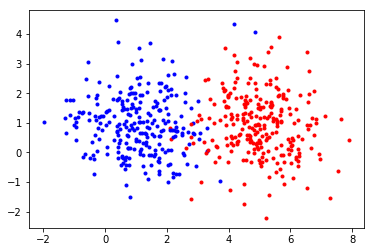

  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 0, batch:     1, batch_acc:    62.50,batch loss: 0.67
epoch: 0, batch:     2, batch_acc:    68.75,batch loss: 0.45
epoch: 0, batch:     3, batch_acc:    81.25,batch loss: 0.36
epoch: 0, batch:     4, batch_acc:    87.50,batch loss: 0.32
epoch: 0, batch:     5, batch_acc:    62.50,batch loss: 0.59
epoch: 0, batch:     6, batch_acc:    68.75,batch loss: 0.52
epoch: 0, batch:     7, batch_acc:    62.50,batch loss: 0.75
epoch: 0, batch:     8, batch_acc:    81.25,batch loss: 0.37
epoch: 0, batch:     9, batch_acc:    75.00,batch loss: 0.43
epoch: 0, batch:    10, batch_acc:    68.75,batch loss: 0.62
epoch: 0, batch:    11, batch_acc:    81.25,batch loss: 0.33
epoch: 0, batch:    12, batch_acc:    62.50,batch loss: 0.61
epoch: 0, batch:    13, batch_acc:    62.50,batch loss: 0.68
epoch: 0, batch:    14, batch_acc:    75.00,batch loss: 0.40
epoch: 0, batch:    15, batch_acc:    81.25,batch loss: 0.22
epoch: 0, batch:    16, batch_acc:    50.00,batch loss: 0.72
epoch: 0, batch:    17, 

 10%|▉         | 49/500 [00:01<00:15, 29.53it/s]

epoch: 50, batch:     1, batch_acc:    81.25,batch loss: 0.35
epoch: 50, batch:     2, batch_acc:    100.00,batch loss: 0.04
epoch: 50, batch:     3, batch_acc:    93.75,batch loss: 0.13
epoch: 50, batch:     4, batch_acc:    93.75,batch loss: 0.11
epoch: 50, batch:     5, batch_acc:    75.00,batch loss: 0.35
epoch: 50, batch:     6, batch_acc:    81.25,batch loss: 0.30
epoch: 50, batch:     7, batch_acc:    56.25,batch loss: 0.45
epoch: 50, batch:     8, batch_acc:    81.25,batch loss: 0.29
epoch: 50, batch:     9, batch_acc:    81.25,batch loss: 0.29
epoch: 50, batch:    10, batch_acc:    75.00,batch loss: 0.41
epoch: 50, batch:    11, batch_acc:    87.50,batch loss: 0.19
epoch: 50, batch:    12, batch_acc:    93.75,batch loss: 0.15
epoch: 50, batch:    13, batch_acc:    81.25,batch loss: 0.28
epoch: 50, batch:    14, batch_acc:    81.25,batch loss: 0.27
epoch: 50, batch:    15, batch_acc:    87.50,batch loss: 0.18
epoch: 50, batch:    16, batch_acc:    75.00,batch loss: 0.40
epoch: 

 20%|██        | 100/500 [00:03<00:14, 27.06it/s]

epoch: 100, batch:     1, batch_acc:    87.50,batch loss: 0.21
epoch: 100, batch:     2, batch_acc:    100.00,batch loss: 0.02
epoch: 100, batch:     3, batch_acc:    93.75,batch loss: 0.10
epoch: 100, batch:     4, batch_acc:    100.00,batch loss: 0.07
epoch: 100, batch:     5, batch_acc:    81.25,batch loss: 0.28
epoch: 100, batch:     6, batch_acc:    87.50,batch loss: 0.16
epoch: 100, batch:     7, batch_acc:    93.75,batch loss: 0.19
epoch: 100, batch:     8, batch_acc:    87.50,batch loss: 0.15
epoch: 100, batch:     9, batch_acc:    87.50,batch loss: 0.17
epoch: 100, batch:    10, batch_acc:    75.00,batch loss: 0.20
epoch: 100, batch:    11, batch_acc:    93.75,batch loss: 0.11
epoch: 100, batch:    12, batch_acc:    100.00,batch loss: 0.04
epoch: 100, batch:    13, batch_acc:    93.75,batch loss: 0.15
epoch: 100, batch:    14, batch_acc:    87.50,batch loss: 0.16
epoch: 100, batch:    15, batch_acc:    93.75,batch loss: 0.13
epoch: 100, batch:    16, batch_acc:    87.50,batch 

 30%|███       | 150/500 [00:05<00:10, 32.22it/s]

epoch: 150, batch:     1, batch_acc:    93.75,batch loss: 0.12
epoch: 150, batch:     2, batch_acc:    100.00,batch loss: 0.02
epoch: 150, batch:     3, batch_acc:    93.75,batch loss: 0.07
epoch: 150, batch:     4, batch_acc:    100.00,batch loss: 0.07
epoch: 150, batch:     5, batch_acc:    81.25,batch loss: 0.24
epoch: 150, batch:     6, batch_acc:    100.00,batch loss: 0.08
epoch: 150, batch:     7, batch_acc:    87.50,batch loss: 0.20
epoch: 150, batch:     8, batch_acc:    93.75,batch loss: 0.08
epoch: 150, batch:     9, batch_acc:    100.00,batch loss: 0.06
epoch: 150, batch:    10, batch_acc:    93.75,batch loss: 0.12
epoch: 150, batch:    11, batch_acc:    93.75,batch loss: 0.06
epoch: 150, batch:    12, batch_acc:    100.00,batch loss: 0.03
epoch: 150, batch:    13, batch_acc:    93.75,batch loss: 0.10
epoch: 150, batch:    14, batch_acc:    93.75,batch loss: 0.12
epoch: 150, batch:    15, batch_acc:    93.75,batch loss: 0.07
epoch: 150, batch:    16, batch_acc:    93.75,batc

 40%|███▉      | 198/500 [00:07<00:09, 31.46it/s]

epoch: 200, batch:     1, batch_acc:    100.00,batch loss: 0.06
epoch: 200, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 200, batch:     3, batch_acc:    100.00,batch loss: 0.04
epoch: 200, batch:     4, batch_acc:    93.75,batch loss: 0.10
epoch: 200, batch:     5, batch_acc:    87.50,batch loss: 0.20
epoch: 200, batch:     6, batch_acc:    100.00,batch loss: 0.04
epoch: 200, batch:     7, batch_acc:    87.50,batch loss: 0.20
epoch: 200, batch:     8, batch_acc:    100.00,batch loss: 0.05
epoch: 200, batch:     9, batch_acc:    100.00,batch loss: 0.03
epoch: 200, batch:    10, batch_acc:    93.75,batch loss: 0.11
epoch: 200, batch:    11, batch_acc:    100.00,batch loss: 0.03
epoch: 200, batch:    12, batch_acc:    100.00,batch loss: 0.02
epoch: 200, batch:    13, batch_acc:    100.00,batch loss: 0.06
epoch: 200, batch:    14, batch_acc:    93.75,batch loss: 0.12
epoch: 200, batch:    15, batch_acc:    100.00,batch loss: 0.04
epoch: 200, batch:    16, batch_acc:    87.50

 50%|█████     | 250/500 [00:09<00:07, 31.30it/s]

epoch: 250, batch:     1, batch_acc:    100.00,batch loss: 0.05
epoch: 250, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 250, batch:     3, batch_acc:    100.00,batch loss: 0.03
epoch: 250, batch:     4, batch_acc:    93.75,batch loss: 0.11
epoch: 250, batch:     5, batch_acc:    87.50,batch loss: 0.19
epoch: 250, batch:     6, batch_acc:    100.00,batch loss: 0.03
epoch: 250, batch:     7, batch_acc:    87.50,batch loss: 0.20
epoch: 250, batch:     8, batch_acc:    100.00,batch loss: 0.03
epoch: 250, batch:     9, batch_acc:    100.00,batch loss: 0.02
epoch: 250, batch:    10, batch_acc:    93.75,batch loss: 0.11
epoch: 250, batch:    11, batch_acc:    100.00,batch loss: 0.02
epoch: 250, batch:    12, batch_acc:    100.00,batch loss: 0.01
epoch: 250, batch:    13, batch_acc:    100.00,batch loss: 0.04
epoch: 250, batch:    14, batch_acc:    87.50,batch loss: 0.12
epoch: 250, batch:    15, batch_acc:    100.00,batch loss: 0.02
epoch: 250, batch:    16, batch_acc:    87.50

 60%|█████▉    | 298/500 [00:10<00:06, 31.19it/s]

epoch: 300, batch:     1, batch_acc:    100.00,batch loss: 0.04
epoch: 300, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 300, batch:     3, batch_acc:    100.00,batch loss: 0.03
epoch: 300, batch:     4, batch_acc:    93.75,batch loss: 0.12
epoch: 300, batch:     5, batch_acc:    87.50,batch loss: 0.18
epoch: 300, batch:     6, batch_acc:    100.00,batch loss: 0.03
epoch: 300, batch:     7, batch_acc:    87.50,batch loss: 0.20
epoch: 300, batch:     8, batch_acc:    100.00,batch loss: 0.03
epoch: 300, batch:     9, batch_acc:    100.00,batch loss: 0.02
epoch: 300, batch:    10, batch_acc:    93.75,batch loss: 0.11
epoch: 300, batch:    11, batch_acc:    100.00,batch loss: 0.01
epoch: 300, batch:    12, batch_acc:    100.00,batch loss: 0.01
epoch: 300, batch:    13, batch_acc:    100.00,batch loss: 0.04
epoch: 300, batch:    14, batch_acc:    87.50,batch loss: 0.11
epoch: 300, batch:    15, batch_acc:    100.00,batch loss: 0.02
epoch: 300, batch:    16, batch_acc:    81.25

 69%|██████▉   | 347/500 [00:12<00:05, 30.22it/s]

epoch: 350, batch:     1, batch_acc:    100.00,batch loss: 0.04
epoch: 350, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 350, batch:     3, batch_acc:    100.00,batch loss: 0.02
epoch: 350, batch:     4, batch_acc:    93.75,batch loss: 0.12
epoch: 350, batch:     5, batch_acc:    87.50,batch loss: 0.18
epoch: 350, batch:     6, batch_acc:    100.00,batch loss: 0.03
epoch: 350, batch:     7, batch_acc:    87.50,batch loss: 0.20
epoch: 350, batch:     8, batch_acc:    100.00,batch loss: 0.02
epoch: 350, batch:     9, batch_acc:    100.00,batch loss: 0.01
epoch: 350, batch:    10, batch_acc:    93.75,batch loss: 0.12
epoch: 350, batch:    11, batch_acc:    100.00,batch loss: 0.01
epoch: 350, batch:    12, batch_acc:    100.00,batch loss: 0.01
epoch: 350, batch:    13, batch_acc:    100.00,batch loss: 0.03
epoch: 350, batch:    14, batch_acc:    87.50,batch loss: 0.11
epoch: 350, batch:    15, batch_acc:    100.00,batch loss: 0.02
epoch: 350, batch:    16, batch_acc:    81.25

 80%|███████▉  | 399/500 [00:14<00:03, 30.83it/s]

epoch: 400, batch:     1, batch_acc:    100.00,batch loss: 0.03
epoch: 400, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 400, batch:     3, batch_acc:    100.00,batch loss: 0.02
epoch: 400, batch:     4, batch_acc:    93.75,batch loss: 0.12
epoch: 400, batch:     5, batch_acc:    87.50,batch loss: 0.18
epoch: 400, batch:     6, batch_acc:    100.00,batch loss: 0.03
epoch: 400, batch:     7, batch_acc:    87.50,batch loss: 0.20
epoch: 400, batch:     8, batch_acc:    100.00,batch loss: 0.02
epoch: 400, batch:     9, batch_acc:    100.00,batch loss: 0.01
epoch: 400, batch:    10, batch_acc:    93.75,batch loss: 0.12
epoch: 400, batch:    11, batch_acc:    100.00,batch loss: 0.01
epoch: 400, batch:    12, batch_acc:    100.00,batch loss: 0.01
epoch: 400, batch:    13, batch_acc:    100.00,batch loss: 0.03
epoch: 400, batch:    14, batch_acc:    87.50,batch loss: 0.11
epoch: 400, batch:    15, batch_acc:    100.00,batch loss: 0.01
epoch: 400, batch:    16, batch_acc:    81.25

 90%|████████▉ | 449/500 [00:16<00:01, 31.50it/s]

epoch: 450, batch:     1, batch_acc:    100.00,batch loss: 0.03
epoch: 450, batch:     2, batch_acc:    100.00,batch loss: 0.00
epoch: 450, batch:     3, batch_acc:    100.00,batch loss: 0.02
epoch: 450, batch:     4, batch_acc:    93.75,batch loss: 0.12
epoch: 450, batch:     5, batch_acc:    87.50,batch loss: 0.18
epoch: 450, batch:     6, batch_acc:    100.00,batch loss: 0.02
epoch: 450, batch:     7, batch_acc:    87.50,batch loss: 0.21
epoch: 450, batch:     8, batch_acc:    100.00,batch loss: 0.02
epoch: 450, batch:     9, batch_acc:    100.00,batch loss: 0.01
epoch: 450, batch:    10, batch_acc:    93.75,batch loss: 0.12
epoch: 450, batch:    11, batch_acc:    100.00,batch loss: 0.01
epoch: 450, batch:    12, batch_acc:    100.00,batch loss: 0.00
epoch: 450, batch:    13, batch_acc:    100.00,batch loss: 0.03
epoch: 450, batch:    14, batch_acc:    87.50,batch loss: 0.11
epoch: 450, batch:    15, batch_acc:    100.00,batch loss: 0.01
epoch: 450, batch:    16, batch_acc:    81.25

100%|██████████| 500/500 [00:17<00:00, 27.84it/s]


In [3]:

X,Y = generate_data()
for i, it in enumerate(X):
    if Y[i] == -1:
        plt.plot(X[i][0], X[i][1], 'r.')
    else:
        plt.plot(X[i][0], X[i][1], 'b.')
plt.show()
layers =[
    {'type':'linear','shape':(2,6)},
    {'type':'tanh'},
    {'type':'linear','shape':(6,6)},
    {'type':'tanh'},
    {'type':'linear','shape':(6,1)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X,Y,opt)


1. Modify the number of hidden nodes and demonstrate the effect the size of the hidden layer has on the performance (both the mean squared error and the number/ratio of misclassifications). How many hidden nodes do you need to perfectly separate all the available data (if manageable at all given your data randomisation)?


In [4]:
layers =[
    {'type':'linear','shape':(2,2)},
    {'type':'tanh'},
    {'type':'linear','shape':(2,2)},
    {'type':'tanh'},
    {'type':'linear','shape':(2,1)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X,Y,opt)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 0, batch:     1, batch_acc:    50.00,batch loss: 0.54
epoch: 0, batch:     2, batch_acc:    37.50,batch loss: 0.61
epoch: 0, batch:     3, batch_acc:    75.00,batch loss: 0.38
epoch: 0, batch:     4, batch_acc:    62.50,batch loss: 0.44
epoch: 0, batch:     5, batch_acc:    62.50,batch loss: 0.42
epoch: 0, batch:     6, batch_acc:    68.75,batch loss: 0.42
epoch: 0, batch:     7, batch_acc:    50.00,batch loss: 0.55
epoch: 0, batch:     8, batch_acc:    62.50,batch loss: 0.45
epoch: 0, batch:     9, batch_acc:    68.75,batch loss: 0.41
epoch: 0, batch:    10, batch_acc:    50.00,batch loss: 0.55
epoch: 0, batch:    11, batch_acc:    62.50,batch loss: 0.43
epoch: 0, batch:    12, batch_acc:    62.50,batch loss: 0.45
epoch: 0, batch:    13, batch_acc:    62.50,batch loss: 0.47
epoch: 0, batch:    14, batch_acc:    75.00,batch loss: 0.38
epoch: 0, batch:    15, batch_acc:    81.25,batch loss: 0.33
epoch: 0, batch:    16, batch_acc:    50.00,batch loss: 0.53
epoch: 0, batch:    17, 

  9%|▉         | 47/500 [00:01<00:15, 28.88it/s]

epoch: 50, batch:     1, batch_acc:    62.50,batch loss: 0.45
epoch: 50, batch:     2, batch_acc:    68.75,batch loss: 0.40
epoch: 50, batch:     3, batch_acc:    81.25,batch loss: 0.34
epoch: 50, batch:     4, batch_acc:    75.00,batch loss: 0.38
epoch: 50, batch:     5, batch_acc:    81.25,batch loss: 0.38
epoch: 50, batch:     6, batch_acc:    75.00,batch loss: 0.39
epoch: 50, batch:     7, batch_acc:    56.25,batch loss: 0.47
epoch: 50, batch:     8, batch_acc:    68.75,batch loss: 0.40
epoch: 50, batch:     9, batch_acc:    81.25,batch loss: 0.34
epoch: 50, batch:    10, batch_acc:    62.50,batch loss: 0.45
epoch: 50, batch:    11, batch_acc:    87.50,batch loss: 0.30
epoch: 50, batch:    12, batch_acc:    68.75,batch loss: 0.39
epoch: 50, batch:    13, batch_acc:    62.50,batch loss: 0.46
epoch: 50, batch:    14, batch_acc:    81.25,batch loss: 0.36
epoch: 50, batch:    15, batch_acc:    87.50,batch loss: 0.31
epoch: 50, batch:    16, batch_acc:    56.25,batch loss: 0.45
epoch: 5

 19%|█▉        | 97/500 [00:03<00:12, 31.76it/s]

epoch: 100, batch:     1, batch_acc:    62.50,batch loss: 0.41
epoch: 100, batch:     2, batch_acc:    93.75,batch loss: 0.26
epoch: 100, batch:     3, batch_acc:    81.25,batch loss: 0.31
epoch: 100, batch:     4, batch_acc:    81.25,batch loss: 0.33
epoch: 100, batch:     5, batch_acc:    81.25,batch loss: 0.32
epoch: 100, batch:     6, batch_acc:    75.00,batch loss: 0.35
epoch: 100, batch:     7, batch_acc:    56.25,batch loss: 0.46
epoch: 100, batch:     8, batch_acc:    75.00,batch loss: 0.33
epoch: 100, batch:     9, batch_acc:    81.25,batch loss: 0.30
epoch: 100, batch:    10, batch_acc:    62.50,batch loss: 0.40
epoch: 100, batch:    11, batch_acc:    87.50,batch loss: 0.22
epoch: 100, batch:    12, batch_acc:    75.00,batch loss: 0.34
epoch: 100, batch:    13, batch_acc:    62.50,batch loss: 0.45
epoch: 100, batch:    14, batch_acc:    81.25,batch loss: 0.32
epoch: 100, batch:    15, batch_acc:    87.50,batch loss: 0.27
epoch: 100, batch:    16, batch_acc:    68.75,batch los

 30%|██▉       | 148/500 [00:05<00:11, 30.68it/s]

epoch: 150, batch:     1, batch_acc:    68.75,batch loss: 0.36
epoch: 150, batch:     2, batch_acc:    100.00,batch loss: 0.10
epoch: 150, batch:     3, batch_acc:    81.25,batch loss: 0.26
epoch: 150, batch:     4, batch_acc:    81.25,batch loss: 0.25
epoch: 150, batch:     5, batch_acc:    87.50,batch loss: 0.26
epoch: 150, batch:     6, batch_acc:    87.50,batch loss: 0.26
epoch: 150, batch:     7, batch_acc:    62.50,batch loss: 0.41
epoch: 150, batch:     8, batch_acc:    93.75,batch loss: 0.20
epoch: 150, batch:     9, batch_acc:    81.25,batch loss: 0.27
epoch: 150, batch:    10, batch_acc:    75.00,batch loss: 0.31
epoch: 150, batch:    11, batch_acc:    93.75,batch loss: 0.15
epoch: 150, batch:    12, batch_acc:    93.75,batch loss: 0.21
epoch: 150, batch:    13, batch_acc:    68.75,batch loss: 0.37
epoch: 150, batch:    14, batch_acc:    87.50,batch loss: 0.27
epoch: 150, batch:    15, batch_acc:    87.50,batch loss: 0.21
epoch: 150, batch:    16, batch_acc:    75.00,batch lo

 40%|███▉      | 198/500 [00:06<00:09, 30.86it/s]

epoch: 200, batch:     1, batch_acc:    81.25,batch loss: 0.25
epoch: 200, batch:     2, batch_acc:    100.00,batch loss: 0.03
epoch: 200, batch:     3, batch_acc:    93.75,batch loss: 0.15
epoch: 200, batch:     4, batch_acc:    93.75,batch loss: 0.13
epoch: 200, batch:     5, batch_acc:    81.25,batch loss: 0.25
epoch: 200, batch:     6, batch_acc:    87.50,batch loss: 0.19
epoch: 200, batch:     7, batch_acc:    81.25,batch loss: 0.26
epoch: 200, batch:     8, batch_acc:    87.50,batch loss: 0.18
epoch: 200, batch:     9, batch_acc:    81.25,batch loss: 0.22
epoch: 200, batch:    10, batch_acc:    81.25,batch loss: 0.22
epoch: 200, batch:    11, batch_acc:    93.75,batch loss: 0.12
epoch: 200, batch:    12, batch_acc:    100.00,batch loss: 0.09
epoch: 200, batch:    13, batch_acc:    87.50,batch loss: 0.22
epoch: 200, batch:    14, batch_acc:    87.50,batch loss: 0.21
epoch: 200, batch:    15, batch_acc:    93.75,batch loss: 0.18
epoch: 200, batch:    16, batch_acc:    81.25,batch l

 50%|████▉     | 249/500 [00:08<00:08, 31.11it/s]

epoch: 250, batch:     1, batch_acc:    87.50,batch loss: 0.21
epoch: 250, batch:     2, batch_acc:    100.00,batch loss: 0.02
epoch: 250, batch:     3, batch_acc:    93.75,batch loss: 0.12
epoch: 250, batch:     4, batch_acc:    100.00,batch loss: 0.09
epoch: 250, batch:     5, batch_acc:    81.25,batch loss: 0.26
epoch: 250, batch:     6, batch_acc:    87.50,batch loss: 0.15
epoch: 250, batch:     7, batch_acc:    93.75,batch loss: 0.20
epoch: 250, batch:     8, batch_acc:    87.50,batch loss: 0.16
epoch: 250, batch:     9, batch_acc:    81.25,batch loss: 0.16
epoch: 250, batch:    10, batch_acc:    81.25,batch loss: 0.16
epoch: 250, batch:    11, batch_acc:    93.75,batch loss: 0.11
epoch: 250, batch:    12, batch_acc:    100.00,batch loss: 0.05
epoch: 250, batch:    13, batch_acc:    93.75,batch loss: 0.16
epoch: 250, batch:    14, batch_acc:    87.50,batch loss: 0.17
epoch: 250, batch:    15, batch_acc:    93.75,batch loss: 0.15
epoch: 250, batch:    16, batch_acc:    87.50,batch 

 59%|█████▉    | 297/500 [00:10<00:06, 31.35it/s]

epoch: 300, batch:     1, batch_acc:    87.50,batch loss: 0.15
epoch: 300, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 300, batch:     3, batch_acc:    93.75,batch loss: 0.09
epoch: 300, batch:     4, batch_acc:    100.00,batch loss: 0.06
epoch: 300, batch:     5, batch_acc:    81.25,batch loss: 0.26
epoch: 300, batch:     6, batch_acc:    93.75,batch loss: 0.09
epoch: 300, batch:     7, batch_acc:    87.50,batch loss: 0.18
epoch: 300, batch:     8, batch_acc:    93.75,batch loss: 0.11
epoch: 300, batch:     9, batch_acc:    100.00,batch loss: 0.09
epoch: 300, batch:    10, batch_acc:    93.75,batch loss: 0.12
epoch: 300, batch:    11, batch_acc:    93.75,batch loss: 0.08
epoch: 300, batch:    12, batch_acc:    100.00,batch loss: 0.03
epoch: 300, batch:    13, batch_acc:    93.75,batch loss: 0.12
epoch: 300, batch:    14, batch_acc:    93.75,batch loss: 0.14
epoch: 300, batch:    15, batch_acc:    93.75,batch loss: 0.12
epoch: 300, batch:    16, batch_acc:    93.75,batch

 70%|███████   | 350/500 [00:12<00:05, 27.99it/s]

epoch: 350, batch:     1, batch_acc:    93.75,batch loss: 0.09
epoch: 350, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 350, batch:     3, batch_acc:    93.75,batch loss: 0.06
epoch: 350, batch:     4, batch_acc:    100.00,batch loss: 0.06
epoch: 350, batch:     5, batch_acc:    81.25,batch loss: 0.23
epoch: 350, batch:     6, batch_acc:    100.00,batch loss: 0.05
epoch: 350, batch:     7, batch_acc:    87.50,batch loss: 0.19
epoch: 350, batch:     8, batch_acc:    93.75,batch loss: 0.07
epoch: 350, batch:     9, batch_acc:    100.00,batch loss: 0.04
epoch: 350, batch:    10, batch_acc:    93.75,batch loss: 0.11
epoch: 350, batch:    11, batch_acc:    93.75,batch loss: 0.05
epoch: 350, batch:    12, batch_acc:    100.00,batch loss: 0.02
epoch: 350, batch:    13, batch_acc:    93.75,batch loss: 0.09
epoch: 350, batch:    14, batch_acc:    93.75,batch loss: 0.12
epoch: 350, batch:    15, batch_acc:    93.75,batch loss: 0.07
epoch: 350, batch:    16, batch_acc:    93.75,batc

 80%|████████  | 400/500 [00:14<00:03, 29.69it/s]

epoch: 400, batch:     1, batch_acc:    100.00,batch loss: 0.05
epoch: 400, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 400, batch:     3, batch_acc:    100.00,batch loss: 0.04
epoch: 400, batch:     4, batch_acc:    93.75,batch loss: 0.09
epoch: 400, batch:     5, batch_acc:    87.50,batch loss: 0.20
epoch: 400, batch:     6, batch_acc:    100.00,batch loss: 0.04
epoch: 400, batch:     7, batch_acc:    87.50,batch loss: 0.19
epoch: 400, batch:     8, batch_acc:    100.00,batch loss: 0.05
epoch: 400, batch:     9, batch_acc:    100.00,batch loss: 0.02
epoch: 400, batch:    10, batch_acc:    93.75,batch loss: 0.11
epoch: 400, batch:    11, batch_acc:    100.00,batch loss: 0.02
epoch: 400, batch:    12, batch_acc:    100.00,batch loss: 0.01
epoch: 400, batch:    13, batch_acc:    100.00,batch loss: 0.05
epoch: 400, batch:    14, batch_acc:    93.75,batch loss: 0.11
epoch: 400, batch:    15, batch_acc:    100.00,batch loss: 0.03
epoch: 400, batch:    16, batch_acc:    87.50

 90%|████████▉ | 449/500 [00:15<00:01, 30.06it/s]

epoch: 450, batch:     1, batch_acc:    100.00,batch loss: 0.03
epoch: 450, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 450, batch:     3, batch_acc:    100.00,batch loss: 0.03
epoch: 450, batch:     4, batch_acc:    93.75,batch loss: 0.11
epoch: 450, batch:     5, batch_acc:    87.50,batch loss: 0.19
epoch: 450, batch:     6, batch_acc:    100.00,batch loss: 0.03
epoch: 450, batch:     7, batch_acc:    87.50,batch loss: 0.20
epoch: 450, batch:     8, batch_acc:    100.00,batch loss: 0.03
epoch: 450, batch:     9, batch_acc:    100.00,batch loss: 0.02
epoch: 450, batch:    10, batch_acc:    93.75,batch loss: 0.12
epoch: 450, batch:    11, batch_acc:    100.00,batch loss: 0.01
epoch: 450, batch:    12, batch_acc:    100.00,batch loss: 0.01
epoch: 450, batch:    13, batch_acc:    100.00,batch loss: 0.04
epoch: 450, batch:    14, batch_acc:    93.75,batch loss: 0.11
epoch: 450, batch:    15, batch_acc:    100.00,batch loss: 0.02
epoch: 450, batch:    16, batch_acc:    87.50

100%|██████████| 500/500 [00:17<00:00, 28.57it/s]


In [5]:
layers =[
    {'type':'linear','shape':(2,1)},
    {'type':'tanh'},
    {'type':'linear','shape':(1,1)},
    {'type':'tanh'},
    {'type':'linear','shape':(1,1)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X,Y,opt)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 0, batch:     1, batch_acc:    37.50,batch loss: 0.96
epoch: 0, batch:     2, batch_acc:    18.75,batch loss: 1.14
epoch: 0, batch:     3, batch_acc:    18.75,batch loss: 1.23
epoch: 0, batch:     4, batch_acc:    12.50,batch loss: 1.27
epoch: 0, batch:     5, batch_acc:    31.25,batch loss: 1.03
epoch: 0, batch:     6, batch_acc:    25.00,batch loss: 1.09
epoch: 0, batch:     7, batch_acc:    43.75,batch loss: 0.87
epoch: 0, batch:     8, batch_acc:    12.50,batch loss: 1.20
epoch: 0, batch:     9, batch_acc:    18.75,batch loss: 1.15
epoch: 0, batch:    10, batch_acc:    31.25,batch loss: 0.95
epoch: 0, batch:    11, batch_acc:    6.25,batch loss: 1.22
epoch: 0, batch:    12, batch_acc:    37.50,batch loss: 1.05
epoch: 0, batch:    13, batch_acc:    37.50,batch loss: 0.99
epoch: 0, batch:    14, batch_acc:    18.75,batch loss: 1.17
epoch: 0, batch:    15, batch_acc:    12.50,batch loss: 1.25
epoch: 0, batch:    16, batch_acc:    37.50,batch loss: 0.84
epoch: 0, batch:    17, b

  9%|▉         | 47/500 [00:01<00:15, 30.05it/s]

epoch: 50, batch:     1, batch_acc:    81.25,batch loss: 0.27
epoch: 50, batch:     2, batch_acc:    100.00,batch loss: 0.03
epoch: 50, batch:     3, batch_acc:    93.75,batch loss: 0.15
epoch: 50, batch:     4, batch_acc:    93.75,batch loss: 0.13
epoch: 50, batch:     5, batch_acc:    81.25,batch loss: 0.25
epoch: 50, batch:     6, batch_acc:    87.50,batch loss: 0.20
epoch: 50, batch:     7, batch_acc:    81.25,batch loss: 0.29
epoch: 50, batch:     8, batch_acc:    87.50,batch loss: 0.19
epoch: 50, batch:     9, batch_acc:    81.25,batch loss: 0.22
epoch: 50, batch:    10, batch_acc:    81.25,batch loss: 0.24
epoch: 50, batch:    11, batch_acc:    93.75,batch loss: 0.12
epoch: 50, batch:    12, batch_acc:    93.75,batch loss: 0.09
epoch: 50, batch:    13, batch_acc:    87.50,batch loss: 0.24
epoch: 50, batch:    14, batch_acc:    81.25,batch loss: 0.21
epoch: 50, batch:    15, batch_acc:    93.75,batch loss: 0.20
epoch: 50, batch:    16, batch_acc:    81.25,batch loss: 0.28
epoch: 

 20%|█▉        | 99/500 [00:03<00:13, 29.19it/s]

epoch: 100, batch:     1, batch_acc:    87.50,batch loss: 0.22
epoch: 100, batch:     2, batch_acc:    100.00,batch loss: 0.02
epoch: 100, batch:     3, batch_acc:    93.75,batch loss: 0.12
epoch: 100, batch:     4, batch_acc:    93.75,batch loss: 0.09
epoch: 100, batch:     5, batch_acc:    81.25,batch loss: 0.25
epoch: 100, batch:     6, batch_acc:    87.50,batch loss: 0.15
epoch: 100, batch:     7, batch_acc:    81.25,batch loss: 0.22
epoch: 100, batch:     8, batch_acc:    87.50,batch loss: 0.15
epoch: 100, batch:     9, batch_acc:    81.25,batch loss: 0.17
epoch: 100, batch:    10, batch_acc:    87.50,batch loss: 0.18
epoch: 100, batch:    11, batch_acc:    93.75,batch loss: 0.10
epoch: 100, batch:    12, batch_acc:    100.00,batch loss: 0.05
epoch: 100, batch:    13, batch_acc:    93.75,batch loss: 0.18
epoch: 100, batch:    14, batch_acc:    87.50,batch loss: 0.18
epoch: 100, batch:    15, batch_acc:    93.75,batch loss: 0.16
epoch: 100, batch:    16, batch_acc:    81.25,batch l

 29%|██▉       | 147/500 [00:05<00:10, 32.49it/s]

epoch: 150, batch:     1, batch_acc:    87.50,batch loss: 0.17
epoch: 150, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 150, batch:     3, batch_acc:    93.75,batch loss: 0.09
epoch: 150, batch:     4, batch_acc:    100.00,batch loss: 0.06
epoch: 150, batch:     5, batch_acc:    81.25,batch loss: 0.25
epoch: 150, batch:     6, batch_acc:    87.50,batch loss: 0.10
epoch: 150, batch:     7, batch_acc:    87.50,batch loss: 0.18
epoch: 150, batch:     8, batch_acc:    93.75,batch loss: 0.11
epoch: 150, batch:     9, batch_acc:    93.75,batch loss: 0.10
epoch: 150, batch:    10, batch_acc:    93.75,batch loss: 0.12
epoch: 150, batch:    11, batch_acc:    93.75,batch loss: 0.08
epoch: 150, batch:    12, batch_acc:    100.00,batch loss: 0.03
epoch: 150, batch:    13, batch_acc:    93.75,batch loss: 0.13
epoch: 150, batch:    14, batch_acc:    87.50,batch loss: 0.14
epoch: 150, batch:    15, batch_acc:    93.75,batch loss: 0.12
epoch: 150, batch:    16, batch_acc:    93.75,batch 

 39%|███▉      | 197/500 [00:06<00:08, 35.09it/s]

epoch: 200, batch:     1, batch_acc:    93.75,batch loss: 0.10
epoch: 200, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 200, batch:     3, batch_acc:    93.75,batch loss: 0.06
epoch: 200, batch:     4, batch_acc:    100.00,batch loss: 0.05
epoch: 200, batch:     5, batch_acc:    81.25,batch loss: 0.23
epoch: 200, batch:     6, batch_acc:    100.00,batch loss: 0.05
epoch: 200, batch:     7, batch_acc:    87.50,batch loss: 0.18
epoch: 200, batch:     8, batch_acc:    93.75,batch loss: 0.07
epoch: 200, batch:     9, batch_acc:    100.00,batch loss: 0.05
epoch: 200, batch:    10, batch_acc:    93.75,batch loss: 0.10
epoch: 200, batch:    11, batch_acc:    93.75,batch loss: 0.05
epoch: 200, batch:    12, batch_acc:    100.00,batch loss: 0.01
epoch: 200, batch:    13, batch_acc:    93.75,batch loss: 0.09
epoch: 200, batch:    14, batch_acc:    93.75,batch loss: 0.12
epoch: 200, batch:    15, batch_acc:    93.75,batch loss: 0.07
epoch: 200, batch:    16, batch_acc:    93.75,batc

 50%|█████     | 250/500 [00:08<00:08, 30.98it/s]

epoch: 250, batch:     1, batch_acc:    100.00,batch loss: 0.05
epoch: 250, batch:     2, batch_acc:    100.00,batch loss: 0.00
epoch: 250, batch:     3, batch_acc:    100.00,batch loss: 0.04
epoch: 250, batch:     4, batch_acc:    93.75,batch loss: 0.08
epoch: 250, batch:     5, batch_acc:    87.50,batch loss: 0.20
epoch: 250, batch:     6, batch_acc:    100.00,batch loss: 0.03
epoch: 250, batch:     7, batch_acc:    87.50,batch loss: 0.19
epoch: 250, batch:     8, batch_acc:    100.00,batch loss: 0.04
epoch: 250, batch:     9, batch_acc:    100.00,batch loss: 0.02
epoch: 250, batch:    10, batch_acc:    93.75,batch loss: 0.11
epoch: 250, batch:    11, batch_acc:    100.00,batch loss: 0.02
epoch: 250, batch:    12, batch_acc:    100.00,batch loss: 0.01
epoch: 250, batch:    13, batch_acc:    100.00,batch loss: 0.05
epoch: 250, batch:    14, batch_acc:    93.75,batch loss: 0.11
epoch: 250, batch:    15, batch_acc:    100.00,batch loss: 0.03
epoch: 250, batch:    16, batch_acc:    87.50

 59%|█████▉    | 297/500 [00:10<00:06, 33.24it/s]

epoch: 300, batch:     1, batch_acc:    100.00,batch loss: 0.03
epoch: 300, batch:     2, batch_acc:    100.00,batch loss: 0.00
epoch: 300, batch:     3, batch_acc:    100.00,batch loss: 0.03
epoch: 300, batch:     4, batch_acc:    93.75,batch loss: 0.10
epoch: 300, batch:     5, batch_acc:    87.50,batch loss: 0.19
epoch: 300, batch:     6, batch_acc:    100.00,batch loss: 0.03
epoch: 300, batch:     7, batch_acc:    87.50,batch loss: 0.20
epoch: 300, batch:     8, batch_acc:    100.00,batch loss: 0.03
epoch: 300, batch:     9, batch_acc:    100.00,batch loss: 0.02
epoch: 300, batch:    10, batch_acc:    93.75,batch loss: 0.11
epoch: 300, batch:    11, batch_acc:    100.00,batch loss: 0.01
epoch: 300, batch:    12, batch_acc:    100.00,batch loss: 0.00
epoch: 300, batch:    13, batch_acc:    100.00,batch loss: 0.03
epoch: 300, batch:    14, batch_acc:    87.50,batch loss: 0.11
epoch: 300, batch:    15, batch_acc:    100.00,batch loss: 0.02
epoch: 300, batch:    16, batch_acc:    87.50

 70%|██████▉   | 348/500 [00:11<00:04, 35.81it/s]

epoch: 350, batch:     1, batch_acc:    100.00,batch loss: 0.03
epoch: 350, batch:     2, batch_acc:    100.00,batch loss: 0.00
epoch: 350, batch:     3, batch_acc:    100.00,batch loss: 0.02
epoch: 350, batch:     4, batch_acc:    93.75,batch loss: 0.11
epoch: 350, batch:     5, batch_acc:    87.50,batch loss: 0.19
epoch: 350, batch:     6, batch_acc:    100.00,batch loss: 0.02
epoch: 350, batch:     7, batch_acc:    87.50,batch loss: 0.20
epoch: 350, batch:     8, batch_acc:    100.00,batch loss: 0.02
epoch: 350, batch:     9, batch_acc:    100.00,batch loss: 0.01
epoch: 350, batch:    10, batch_acc:    93.75,batch loss: 0.12
epoch: 350, batch:    11, batch_acc:    100.00,batch loss: 0.01
epoch: 350, batch:    12, batch_acc:    100.00,batch loss: 0.00
epoch: 350, batch:    13, batch_acc:    100.00,batch loss: 0.03
epoch: 350, batch:    14, batch_acc:    87.50,batch loss: 0.11
epoch: 350, batch:    15, batch_acc:    100.00,batch loss: 0.02
epoch: 350, batch:    16, batch_acc:    87.50

 79%|███████▉  | 397/500 [00:13<00:03, 34.07it/s]

epoch: 400, batch:     1, batch_acc:    100.00,batch loss: 0.03
epoch: 400, batch:     2, batch_acc:    100.00,batch loss: 0.00
epoch: 400, batch:     3, batch_acc:    100.00,batch loss: 0.02
epoch: 400, batch:     4, batch_acc:    93.75,batch loss: 0.11
epoch: 400, batch:     5, batch_acc:    87.50,batch loss: 0.19
epoch: 400, batch:     6, batch_acc:    100.00,batch loss: 0.02
epoch: 400, batch:     7, batch_acc:    87.50,batch loss: 0.20
epoch: 400, batch:     8, batch_acc:    100.00,batch loss: 0.02
epoch: 400, batch:     9, batch_acc:    100.00,batch loss: 0.01
epoch: 400, batch:    10, batch_acc:    93.75,batch loss: 0.12
epoch: 400, batch:    11, batch_acc:    100.00,batch loss: 0.00
epoch: 400, batch:    12, batch_acc:    100.00,batch loss: 0.00
epoch: 400, batch:    13, batch_acc:    100.00,batch loss: 0.02
epoch: 400, batch:    14, batch_acc:    87.50,batch loss: 0.11
epoch: 400, batch:    15, batch_acc:    100.00,batch loss: 0.01
epoch: 400, batch:    16, batch_acc:    81.25

 90%|█████████ | 450/500 [00:15<00:01, 31.90it/s]

epoch: 450, batch:     1, batch_acc:    100.00,batch loss: 0.02
epoch: 450, batch:     2, batch_acc:    100.00,batch loss: 0.00
epoch: 450, batch:     3, batch_acc:    100.00,batch loss: 0.02
epoch: 450, batch:     4, batch_acc:    93.75,batch loss: 0.11
epoch: 450, batch:     5, batch_acc:    87.50,batch loss: 0.19
epoch: 450, batch:     6, batch_acc:    100.00,batch loss: 0.02
epoch: 450, batch:     7, batch_acc:    87.50,batch loss: 0.20
epoch: 450, batch:     8, batch_acc:    100.00,batch loss: 0.02
epoch: 450, batch:     9, batch_acc:    100.00,batch loss: 0.01
epoch: 450, batch:    10, batch_acc:    93.75,batch loss: 0.12
epoch: 450, batch:    11, batch_acc:    100.00,batch loss: 0.00
epoch: 450, batch:    12, batch_acc:    100.00,batch loss: 0.00
epoch: 450, batch:    13, batch_acc:    100.00,batch loss: 0.02
epoch: 450, batch:    14, batch_acc:    87.50,batch loss: 0.11
epoch: 450, batch:    15, batch_acc:    100.00,batch loss: 0.01
epoch: 450, batch:    16, batch_acc:    81.25

100%|██████████| 500/500 [00:16<00:00, 30.02it/s]


In [6]:
layers =[
    {'type':'linear','shape':(2,8)},
    {'type':'tanh'},
    {'type':'linear','shape':(8,8)},
    {'type':'tanh'},
    {'type':'linear','shape':(8,1)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X,Y,opt)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 0, batch:     1, batch_acc:    50.00,batch loss: 0.88
epoch: 0, batch:     2, batch_acc:    37.50,batch loss: 1.04
epoch: 0, batch:     3, batch_acc:    75.00,batch loss: 0.46
epoch: 0, batch:     4, batch_acc:    62.50,batch loss: 0.57
epoch: 0, batch:     5, batch_acc:    62.50,batch loss: 0.63
epoch: 0, batch:     6, batch_acc:    68.75,batch loss: 0.58
epoch: 0, batch:     7, batch_acc:    50.00,batch loss: 0.94
epoch: 0, batch:     8, batch_acc:    62.50,batch loss: 0.61
epoch: 0, batch:     9, batch_acc:    62.50,batch loss: 0.55
epoch: 0, batch:    10, batch_acc:    50.00,batch loss: 0.87
epoch: 0, batch:    11, batch_acc:    62.50,batch loss: 0.61
epoch: 0, batch:    12, batch_acc:    62.50,batch loss: 0.71
epoch: 0, batch:    13, batch_acc:    62.50,batch loss: 0.73
epoch: 0, batch:    14, batch_acc:    75.00,batch loss: 0.47
epoch: 0, batch:    15, batch_acc:    81.25,batch loss: 0.31
epoch: 0, batch:    16, batch_acc:    50.00,batch loss: 0.92
epoch: 0, batch:    17, 

  9%|▉         | 47/500 [00:01<00:14, 31.36it/s]

epoch: 50, batch:     1, batch_acc:    87.50,batch loss: 0.17
epoch: 50, batch:     2, batch_acc:    100.00,batch loss: 0.02
epoch: 50, batch:     3, batch_acc:    87.50,batch loss: 0.16
epoch: 50, batch:     4, batch_acc:    87.50,batch loss: 0.20
epoch: 50, batch:     5, batch_acc:    93.75,batch loss: 0.18
epoch: 50, batch:     6, batch_acc:    81.25,batch loss: 0.28
epoch: 50, batch:     7, batch_acc:    68.75,batch loss: 0.47
epoch: 50, batch:     8, batch_acc:    81.25,batch loss: 0.27
epoch: 50, batch:     9, batch_acc:    87.50,batch loss: 0.21
epoch: 50, batch:    10, batch_acc:    87.50,batch loss: 0.24
epoch: 50, batch:    11, batch_acc:    81.25,batch loss: 0.13
epoch: 50, batch:    12, batch_acc:    87.50,batch loss: 0.19
epoch: 50, batch:    13, batch_acc:    75.00,batch loss: 0.28
epoch: 50, batch:    14, batch_acc:    81.25,batch loss: 0.35
epoch: 50, batch:    15, batch_acc:    87.50,batch loss: 0.21
epoch: 50, batch:    16, batch_acc:    81.25,batch loss: 0.18
epoch: 

 19%|█▉        | 97/500 [00:03<00:12, 31.37it/s]

epoch: 100, batch:     1, batch_acc:    87.50,batch loss: 0.13
epoch: 100, batch:     2, batch_acc:    100.00,batch loss: 0.02
epoch: 100, batch:     3, batch_acc:    87.50,batch loss: 0.16
epoch: 100, batch:     4, batch_acc:    87.50,batch loss: 0.18
epoch: 100, batch:     5, batch_acc:    93.75,batch loss: 0.15
epoch: 100, batch:     6, batch_acc:    87.50,batch loss: 0.19
epoch: 100, batch:     7, batch_acc:    68.75,batch loss: 0.37
epoch: 100, batch:     8, batch_acc:    81.25,batch loss: 0.27
epoch: 100, batch:     9, batch_acc:    87.50,batch loss: 0.18
epoch: 100, batch:    10, batch_acc:    87.50,batch loss: 0.18
epoch: 100, batch:    11, batch_acc:    93.75,batch loss: 0.12
epoch: 100, batch:    12, batch_acc:    93.75,batch loss: 0.13
epoch: 100, batch:    13, batch_acc:    93.75,batch loss: 0.21
epoch: 100, batch:    14, batch_acc:    81.25,batch loss: 0.29
epoch: 100, batch:    15, batch_acc:    87.50,batch loss: 0.19
epoch: 100, batch:    16, batch_acc:    87.50,batch lo

 30%|██▉       | 149/500 [00:05<00:11, 31.09it/s]

epoch: 150, batch:     1, batch_acc:    100.00,batch loss: 0.11
epoch: 150, batch:     2, batch_acc:    100.00,batch loss: 0.02
epoch: 150, batch:     3, batch_acc:    87.50,batch loss: 0.15
epoch: 150, batch:     4, batch_acc:    87.50,batch loss: 0.15
epoch: 150, batch:     5, batch_acc:    93.75,batch loss: 0.14
epoch: 150, batch:     6, batch_acc:    87.50,batch loss: 0.16
epoch: 150, batch:     7, batch_acc:    68.75,batch loss: 0.29
epoch: 150, batch:     8, batch_acc:    81.25,batch loss: 0.28
epoch: 150, batch:     9, batch_acc:    87.50,batch loss: 0.16
epoch: 150, batch:    10, batch_acc:    87.50,batch loss: 0.16
epoch: 150, batch:    11, batch_acc:    93.75,batch loss: 0.12
epoch: 150, batch:    12, batch_acc:    93.75,batch loss: 0.09
epoch: 150, batch:    13, batch_acc:    93.75,batch loss: 0.16
epoch: 150, batch:    14, batch_acc:    81.25,batch loss: 0.25
epoch: 150, batch:    15, batch_acc:    93.75,batch loss: 0.17
epoch: 150, batch:    16, batch_acc:    100.00,batch 

 40%|███▉      | 198/500 [00:06<00:10, 29.42it/s]

epoch: 200, batch:     1, batch_acc:    100.00,batch loss: 0.08
epoch: 200, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 200, batch:     3, batch_acc:    93.75,batch loss: 0.13
epoch: 200, batch:     4, batch_acc:    87.50,batch loss: 0.11
epoch: 200, batch:     5, batch_acc:    87.50,batch loss: 0.15
epoch: 200, batch:     6, batch_acc:    93.75,batch loss: 0.13
epoch: 200, batch:     7, batch_acc:    81.25,batch loss: 0.23
epoch: 200, batch:     8, batch_acc:    81.25,batch loss: 0.27
epoch: 200, batch:     9, batch_acc:    87.50,batch loss: 0.14
epoch: 200, batch:    10, batch_acc:    87.50,batch loss: 0.14
epoch: 200, batch:    11, batch_acc:    93.75,batch loss: 0.11
epoch: 200, batch:    12, batch_acc:    93.75,batch loss: 0.06
epoch: 200, batch:    13, batch_acc:    100.00,batch loss: 0.11
epoch: 200, batch:    14, batch_acc:    81.25,batch loss: 0.22
epoch: 200, batch:    15, batch_acc:    93.75,batch loss: 0.15
epoch: 200, batch:    16, batch_acc:    100.00,batch

 50%|████▉     | 248/500 [00:08<00:08, 29.54it/s]

epoch: 250, batch:     1, batch_acc:    100.00,batch loss: 0.06
epoch: 250, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 250, batch:     3, batch_acc:    93.75,batch loss: 0.12
epoch: 250, batch:     4, batch_acc:    93.75,batch loss: 0.08
epoch: 250, batch:     5, batch_acc:    87.50,batch loss: 0.16
epoch: 250, batch:     6, batch_acc:    93.75,batch loss: 0.10
epoch: 250, batch:     7, batch_acc:    87.50,batch loss: 0.18
epoch: 250, batch:     8, batch_acc:    81.25,batch loss: 0.25
epoch: 250, batch:     9, batch_acc:    87.50,batch loss: 0.11
epoch: 250, batch:    10, batch_acc:    87.50,batch loss: 0.12
epoch: 250, batch:    11, batch_acc:    93.75,batch loss: 0.10
epoch: 250, batch:    12, batch_acc:    100.00,batch loss: 0.04
epoch: 250, batch:    13, batch_acc:    100.00,batch loss: 0.09
epoch: 250, batch:    14, batch_acc:    81.25,batch loss: 0.18
epoch: 250, batch:    15, batch_acc:    93.75,batch loss: 0.14
epoch: 250, batch:    16, batch_acc:    100.00,batc

 60%|██████    | 300/500 [00:10<00:07, 26.95it/s]

epoch: 300, batch:     1, batch_acc:    100.00,batch loss: 0.06
epoch: 300, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 300, batch:     3, batch_acc:    93.75,batch loss: 0.10
epoch: 300, batch:     4, batch_acc:    100.00,batch loss: 0.05
epoch: 300, batch:     5, batch_acc:    87.50,batch loss: 0.18
epoch: 300, batch:     6, batch_acc:    93.75,batch loss: 0.07
epoch: 300, batch:     7, batch_acc:    93.75,batch loss: 0.14
epoch: 300, batch:     8, batch_acc:    87.50,batch loss: 0.21
epoch: 300, batch:     9, batch_acc:    93.75,batch loss: 0.08
epoch: 300, batch:    10, batch_acc:    93.75,batch loss: 0.11
epoch: 300, batch:    11, batch_acc:    93.75,batch loss: 0.10
epoch: 300, batch:    12, batch_acc:    100.00,batch loss: 0.02
epoch: 300, batch:    13, batch_acc:    100.00,batch loss: 0.07
epoch: 300, batch:    14, batch_acc:    87.50,batch loss: 0.15
epoch: 300, batch:    15, batch_acc:    93.75,batch loss: 0.13
epoch: 300, batch:    16, batch_acc:    93.75,batc

 70%|███████   | 350/500 [00:12<00:04, 30.91it/s]

epoch: 350, batch:     1, batch_acc:    100.00,batch loss: 0.05
epoch: 350, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 350, batch:     3, batch_acc:    93.75,batch loss: 0.09
epoch: 350, batch:     4, batch_acc:    100.00,batch loss: 0.03
epoch: 350, batch:     5, batch_acc:    87.50,batch loss: 0.19
epoch: 350, batch:     6, batch_acc:    93.75,batch loss: 0.05
epoch: 350, batch:     7, batch_acc:    93.75,batch loss: 0.13
epoch: 350, batch:     8, batch_acc:    87.50,batch loss: 0.18
epoch: 350, batch:     9, batch_acc:    100.00,batch loss: 0.05
epoch: 350, batch:    10, batch_acc:    93.75,batch loss: 0.11
epoch: 350, batch:    11, batch_acc:    93.75,batch loss: 0.09
epoch: 350, batch:    12, batch_acc:    100.00,batch loss: 0.02
epoch: 350, batch:    13, batch_acc:    100.00,batch loss: 0.06
epoch: 350, batch:    14, batch_acc:    93.75,batch loss: 0.12
epoch: 350, batch:    15, batch_acc:    93.75,batch loss: 0.12
epoch: 350, batch:    16, batch_acc:    87.50,bat

 80%|███████▉  | 399/500 [00:14<00:03, 30.41it/s]

epoch: 400, batch:     1, batch_acc:    100.00,batch loss: 0.05
epoch: 400, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 400, batch:     3, batch_acc:    93.75,batch loss: 0.08
epoch: 400, batch:     4, batch_acc:    100.00,batch loss: 0.03
epoch: 400, batch:     5, batch_acc:    87.50,batch loss: 0.19
epoch: 400, batch:     6, batch_acc:    100.00,batch loss: 0.04
epoch: 400, batch:     7, batch_acc:    93.75,batch loss: 0.12
epoch: 400, batch:     8, batch_acc:    87.50,batch loss: 0.16
epoch: 400, batch:     9, batch_acc:    100.00,batch loss: 0.04
epoch: 400, batch:    10, batch_acc:    93.75,batch loss: 0.11
epoch: 400, batch:    11, batch_acc:    93.75,batch loss: 0.08
epoch: 400, batch:    12, batch_acc:    100.00,batch loss: 0.01
epoch: 400, batch:    13, batch_acc:    100.00,batch loss: 0.06
epoch: 400, batch:    14, batch_acc:    93.75,batch loss: 0.11
epoch: 400, batch:    15, batch_acc:    93.75,batch loss: 0.11
epoch: 400, batch:    16, batch_acc:    87.50,ba

 90%|█████████ | 450/500 [00:15<00:01, 31.21it/s]

epoch: 450, batch:     1, batch_acc:    100.00,batch loss: 0.04
epoch: 450, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 450, batch:     3, batch_acc:    93.75,batch loss: 0.07
epoch: 450, batch:     4, batch_acc:    100.00,batch loss: 0.02
epoch: 450, batch:     5, batch_acc:    87.50,batch loss: 0.20
epoch: 450, batch:     6, batch_acc:    100.00,batch loss: 0.03
epoch: 450, batch:     7, batch_acc:    93.75,batch loss: 0.12
epoch: 450, batch:     8, batch_acc:    87.50,batch loss: 0.14
epoch: 450, batch:     9, batch_acc:    100.00,batch loss: 0.03
epoch: 450, batch:    10, batch_acc:    93.75,batch loss: 0.11
epoch: 450, batch:    11, batch_acc:    93.75,batch loss: 0.07
epoch: 450, batch:    12, batch_acc:    100.00,batch loss: 0.01
epoch: 450, batch:    13, batch_acc:    100.00,batch loss: 0.05
epoch: 450, batch:    14, batch_acc:    93.75,batch loss: 0.10
epoch: 450, batch:    15, batch_acc:    93.75,batch loss: 0.11
epoch: 450, batch:    16, batch_acc:    87.50,ba

100%|██████████| 500/500 [00:17<00:00, 28.33it/s]


In [7]:
layers =[
    {'type':'linear','shape':(2,16)},
    {'type':'tanh'},
    {'type':'linear','shape':(16,16)},
    {'type':'tanh'},
    {'type':'linear','shape':(16,1)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X,Y,opt)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 0, batch:     1, batch_acc:    50.00,batch loss: 0.95
epoch: 0, batch:     2, batch_acc:    25.00,batch loss: 1.33
epoch: 0, batch:     3, batch_acc:    56.25,batch loss: 0.83
epoch: 0, batch:     4, batch_acc:    56.25,batch loss: 0.83
epoch: 0, batch:     5, batch_acc:    68.75,batch loss: 0.62
epoch: 0, batch:     6, batch_acc:    62.50,batch loss: 0.61
epoch: 0, batch:     7, batch_acc:    43.75,batch loss: 1.08
epoch: 0, batch:     8, batch_acc:    56.25,batch loss: 0.80
epoch: 0, batch:     9, batch_acc:    56.25,batch loss: 0.80
epoch: 0, batch:    10, batch_acc:    43.75,batch loss: 0.95
epoch: 0, batch:    11, batch_acc:    43.75,batch loss: 0.96
epoch: 0, batch:    12, batch_acc:    56.25,batch loss: 0.84
epoch: 0, batch:    13, batch_acc:    62.50,batch loss: 0.73
epoch: 0, batch:    14, batch_acc:    62.50,batch loss: 0.72
epoch: 0, batch:    15, batch_acc:    62.50,batch loss: 0.65
epoch: 0, batch:    16, batch_acc:    50.00,batch loss: 0.96
epoch: 0, batch:    17, 

 10%|█         | 50/500 [00:01<00:15, 29.53it/s]

epoch: 50, batch:     1, batch_acc:    93.75,batch loss: 0.14
epoch: 50, batch:     2, batch_acc:    100.00,batch loss: 0.04
epoch: 50, batch:     3, batch_acc:    93.75,batch loss: 0.13
epoch: 50, batch:     4, batch_acc:    93.75,batch loss: 0.10
epoch: 50, batch:     5, batch_acc:    87.50,batch loss: 0.20
epoch: 50, batch:     6, batch_acc:    93.75,batch loss: 0.12
epoch: 50, batch:     7, batch_acc:    87.50,batch loss: 0.23
epoch: 50, batch:     8, batch_acc:    93.75,batch loss: 0.14
epoch: 50, batch:     9, batch_acc:    87.50,batch loss: 0.12
epoch: 50, batch:    10, batch_acc:    93.75,batch loss: 0.14
epoch: 50, batch:    11, batch_acc:    93.75,batch loss: 0.09
epoch: 50, batch:    12, batch_acc:    100.00,batch loss: 0.07
epoch: 50, batch:    13, batch_acc:    93.75,batch loss: 0.14
epoch: 50, batch:    14, batch_acc:    87.50,batch loss: 0.19
epoch: 50, batch:    15, batch_acc:    93.75,batch loss: 0.15
epoch: 50, batch:    16, batch_acc:    93.75,batch loss: 0.19
epoch:

 20%|█▉        | 98/500 [00:03<00:14, 27.84it/s]

epoch: 100, batch:     1, batch_acc:    100.00,batch loss: 0.08
epoch: 100, batch:     2, batch_acc:    100.00,batch loss: 0.02
epoch: 100, batch:     3, batch_acc:    93.75,batch loss: 0.10
epoch: 100, batch:     4, batch_acc:    100.00,batch loss: 0.07
epoch: 100, batch:     5, batch_acc:    87.50,batch loss: 0.17
epoch: 100, batch:     6, batch_acc:    93.75,batch loss: 0.08
epoch: 100, batch:     7, batch_acc:    93.75,batch loss: 0.19
epoch: 100, batch:     8, batch_acc:    93.75,batch loss: 0.10
epoch: 100, batch:     9, batch_acc:    93.75,batch loss: 0.08
epoch: 100, batch:    10, batch_acc:    87.50,batch loss: 0.11
epoch: 100, batch:    11, batch_acc:    100.00,batch loss: 0.05
epoch: 100, batch:    12, batch_acc:    100.00,batch loss: 0.04
epoch: 100, batch:    13, batch_acc:    100.00,batch loss: 0.09
epoch: 100, batch:    14, batch_acc:    87.50,batch loss: 0.16
epoch: 100, batch:    15, batch_acc:    93.75,batch loss: 0.11
epoch: 100, batch:    16, batch_acc:    93.75,bat

 30%|███       | 150/500 [00:05<00:11, 29.57it/s]

epoch: 150, batch:     1, batch_acc:    100.00,batch loss: 0.05
epoch: 150, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 150, batch:     3, batch_acc:    93.75,batch loss: 0.09
epoch: 150, batch:     4, batch_acc:    100.00,batch loss: 0.05
epoch: 150, batch:     5, batch_acc:    87.50,batch loss: 0.17
epoch: 150, batch:     6, batch_acc:    93.75,batch loss: 0.06
epoch: 150, batch:     7, batch_acc:    87.50,batch loss: 0.18
epoch: 150, batch:     8, batch_acc:    93.75,batch loss: 0.08
epoch: 150, batch:     9, batch_acc:    100.00,batch loss: 0.06
epoch: 150, batch:    10, batch_acc:    93.75,batch loss: 0.10
epoch: 150, batch:    11, batch_acc:    100.00,batch loss: 0.03
epoch: 150, batch:    12, batch_acc:    100.00,batch loss: 0.02
epoch: 150, batch:    13, batch_acc:    100.00,batch loss: 0.06
epoch: 150, batch:    14, batch_acc:    87.50,batch loss: 0.13
epoch: 150, batch:    15, batch_acc:    93.75,batch loss: 0.09
epoch: 150, batch:    16, batch_acc:    93.75,ba

 40%|████      | 200/500 [00:07<00:09, 30.43it/s]

epoch: 200, batch:     1, batch_acc:    100.00,batch loss: 0.03
epoch: 200, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 200, batch:     3, batch_acc:    93.75,batch loss: 0.07
epoch: 200, batch:     4, batch_acc:    100.00,batch loss: 0.05
epoch: 200, batch:     5, batch_acc:    87.50,batch loss: 0.17
epoch: 200, batch:     6, batch_acc:    93.75,batch loss: 0.05
epoch: 200, batch:     7, batch_acc:    87.50,batch loss: 0.18
epoch: 200, batch:     8, batch_acc:    93.75,batch loss: 0.07
epoch: 200, batch:     9, batch_acc:    100.00,batch loss: 0.05
epoch: 200, batch:    10, batch_acc:    93.75,batch loss: 0.10
epoch: 200, batch:    11, batch_acc:    100.00,batch loss: 0.02
epoch: 200, batch:    12, batch_acc:    100.00,batch loss: 0.02
epoch: 200, batch:    13, batch_acc:    100.00,batch loss: 0.05
epoch: 200, batch:    14, batch_acc:    93.75,batch loss: 0.12
epoch: 200, batch:    15, batch_acc:    93.75,batch loss: 0.07
epoch: 200, batch:    16, batch_acc:    93.75,ba

 50%|████▉     | 249/500 [00:08<00:08, 30.34it/s]

epoch: 250, batch:     1, batch_acc:    100.00,batch loss: 0.03
epoch: 250, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 250, batch:     3, batch_acc:    93.75,batch loss: 0.06
epoch: 250, batch:     4, batch_acc:    100.00,batch loss: 0.04
epoch: 250, batch:     5, batch_acc:    87.50,batch loss: 0.17
epoch: 250, batch:     6, batch_acc:    93.75,batch loss: 0.04
epoch: 250, batch:     7, batch_acc:    87.50,batch loss: 0.18
epoch: 250, batch:     8, batch_acc:    93.75,batch loss: 0.06
epoch: 250, batch:     9, batch_acc:    100.00,batch loss: 0.04
epoch: 250, batch:    10, batch_acc:    93.75,batch loss: 0.10
epoch: 250, batch:    11, batch_acc:    100.00,batch loss: 0.02
epoch: 250, batch:    12, batch_acc:    100.00,batch loss: 0.01
epoch: 250, batch:    13, batch_acc:    100.00,batch loss: 0.04
epoch: 250, batch:    14, batch_acc:    93.75,batch loss: 0.11
epoch: 250, batch:    15, batch_acc:    93.75,batch loss: 0.06
epoch: 250, batch:    16, batch_acc:    93.75,ba

 60%|█████▉    | 298/500 [00:10<00:06, 29.10it/s]

epoch: 300, batch:     1, batch_acc:    100.00,batch loss: 0.02
epoch: 300, batch:     2, batch_acc:    100.00,batch loss: 0.01
epoch: 300, batch:     3, batch_acc:    93.75,batch loss: 0.06
epoch: 300, batch:     4, batch_acc:    100.00,batch loss: 0.04
epoch: 300, batch:     5, batch_acc:    87.50,batch loss: 0.17
epoch: 300, batch:     6, batch_acc:    93.75,batch loss: 0.04
epoch: 300, batch:     7, batch_acc:    87.50,batch loss: 0.19
epoch: 300, batch:     8, batch_acc:    93.75,batch loss: 0.05
epoch: 300, batch:     9, batch_acc:    100.00,batch loss: 0.03
epoch: 300, batch:    10, batch_acc:    93.75,batch loss: 0.10
epoch: 300, batch:    11, batch_acc:    100.00,batch loss: 0.01
epoch: 300, batch:    12, batch_acc:    100.00,batch loss: 0.01
epoch: 300, batch:    13, batch_acc:    100.00,batch loss: 0.03
epoch: 300, batch:    14, batch_acc:    93.75,batch loss: 0.11
epoch: 300, batch:    15, batch_acc:    93.75,batch loss: 0.05
epoch: 300, batch:    16, batch_acc:    87.50,ba

 70%|██████▉   | 348/500 [00:12<00:05, 30.31it/s]

epoch: 350, batch:     1, batch_acc:    100.00,batch loss: 0.02
epoch: 350, batch:     2, batch_acc:    100.00,batch loss: 0.00
epoch: 350, batch:     3, batch_acc:    93.75,batch loss: 0.05
epoch: 350, batch:     4, batch_acc:    100.00,batch loss: 0.05
epoch: 350, batch:     5, batch_acc:    87.50,batch loss: 0.18
epoch: 350, batch:     6, batch_acc:    100.00,batch loss: 0.04
epoch: 350, batch:     7, batch_acc:    87.50,batch loss: 0.19
epoch: 350, batch:     8, batch_acc:    93.75,batch loss: 0.05
epoch: 350, batch:     9, batch_acc:    100.00,batch loss: 0.02
epoch: 350, batch:    10, batch_acc:    93.75,batch loss: 0.10
epoch: 350, batch:    11, batch_acc:    100.00,batch loss: 0.01
epoch: 350, batch:    12, batch_acc:    100.00,batch loss: 0.01
epoch: 350, batch:    13, batch_acc:    100.00,batch loss: 0.03
epoch: 350, batch:    14, batch_acc:    93.75,batch loss: 0.10
epoch: 350, batch:    15, batch_acc:    100.00,batch loss: 0.04
epoch: 350, batch:    16, batch_acc:    87.50,

 80%|███████▉  | 398/500 [00:14<00:03, 32.42it/s]

epoch: 400, batch:     1, batch_acc:    100.00,batch loss: 0.02
epoch: 400, batch:     2, batch_acc:    100.00,batch loss: 0.00
epoch: 400, batch:     3, batch_acc:    93.75,batch loss: 0.05
epoch: 400, batch:     4, batch_acc:    100.00,batch loss: 0.05
epoch: 400, batch:     5, batch_acc:    87.50,batch loss: 0.18
epoch: 400, batch:     6, batch_acc:    100.00,batch loss: 0.03
epoch: 400, batch:     7, batch_acc:    87.50,batch loss: 0.19
epoch: 400, batch:     8, batch_acc:    93.75,batch loss: 0.04
epoch: 400, batch:     9, batch_acc:    100.00,batch loss: 0.02
epoch: 400, batch:    10, batch_acc:    93.75,batch loss: 0.10
epoch: 400, batch:    11, batch_acc:    100.00,batch loss: 0.01
epoch: 400, batch:    12, batch_acc:    100.00,batch loss: 0.01
epoch: 400, batch:    13, batch_acc:    100.00,batch loss: 0.03
epoch: 400, batch:    14, batch_acc:    93.75,batch loss: 0.10
epoch: 400, batch:    15, batch_acc:    100.00,batch loss: 0.04
epoch: 400, batch:    16, batch_acc:    87.50,

 90%|█████████ | 450/500 [00:16<00:01, 30.11it/s]

epoch: 450, batch:     1, batch_acc:    100.00,batch loss: 0.02
epoch: 450, batch:     2, batch_acc:    100.00,batch loss: 0.00
epoch: 450, batch:     3, batch_acc:    93.75,batch loss: 0.04
epoch: 450, batch:     4, batch_acc:    100.00,batch loss: 0.05
epoch: 450, batch:     5, batch_acc:    87.50,batch loss: 0.18
epoch: 450, batch:     6, batch_acc:    100.00,batch loss: 0.03
epoch: 450, batch:     7, batch_acc:    87.50,batch loss: 0.19
epoch: 450, batch:     8, batch_acc:    100.00,batch loss: 0.04
epoch: 450, batch:     9, batch_acc:    100.00,batch loss: 0.02
epoch: 450, batch:    10, batch_acc:    93.75,batch loss: 0.11
epoch: 450, batch:    11, batch_acc:    100.00,batch loss: 0.01
epoch: 450, batch:    12, batch_acc:    100.00,batch loss: 0.00
epoch: 450, batch:    13, batch_acc:    100.00,batch loss: 0.02
epoch: 450, batch:    14, batch_acc:    93.75,batch loss: 0.10
epoch: 450, batch:    15, batch_acc:    100.00,batch loss: 0.03
epoch: 450, batch:    16, batch_acc:    87.50

100%|██████████| 500/500 [00:18<00:00, 27.46it/s]


2.How do the learning/error curves for the training and the validation sets compare? Are they similar? In what cases do you observe more dissimilarity?

In [ ]:
n = len(Y)
p = n*5//4
X_train,Y_train = X[:p,],Y[:p,]

3.How do these curves and the network performance depend on the size of the hidden layer in various training/validation data configurations (the aforementioned subsampling options)

4.Is there any difference between a batch and sequential learning approach in terms of the validation performance?


5.Make an attempt at approximating the resulting decision boundary, i.e. where the network output is 0 (between the target labels of -1 and 1 for two classes, respectively).